In [2]:
# Importar bibliotecas
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from osgeo import ogr
from shapely import wkt
import geopy.distance
from shapely import geometry, ops
from shapely.geometry import shape
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import LineString, Point
import scipy.stats as stats
import shapely
import sklearn
import geoplot
import osmnx as ox
import networkx as nx


C:\Users\Adm\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Adm\Anaconda3\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.7.0-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
In C:\Users\Adm\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Adm\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Adm\Anaconda3\lib\site-packages\matplotlib\mpl-data\

# 0. Importar Bancos de dados

**A) Pesquisa Origem-Destino (moldar o banco de dados)**

In [3]:
import pandas as pd
import pyreadstat as statread
#Importar dados OD 2017
od_RMSP_2017, meta=statread.read_sav('C:/Users/Adm/Desktop/Lucas/Mestrado USP/Dissertação/Dados/Pesquisas OD/OD 2017/Banco de dados/OD_2017.sav')
print("Total de observacoes da amostra:",len(od_RMSP_2017),"obs")
print("Equivalente a ", od_RMSP_2017["fe_via"].sum(), "viagens")

#Filtrar viagens realizadas com origem e destino na cidade de Sao Paulo
od_2017=od_RMSP_2017[(od_RMSP_2017["muni_o"]==36)&(od_RMSP_2017["muni_d"]==36)].reset_index(drop=True).fillna(0)
print("Viagens com origem e destino na cidade de Sao Paulo:",len(od_2017),"obs")
print("Equivalente a ", od_2017["fe_via"].sum(), "viagens")

#Aplicar conceito de Producao e Atracao de viagens (home-based trips)
od_2017['producao'] = np.where(od_2017['motivo_d']==8, od_2017['zona_d'],od_2017['zona_o'])
od_2017['atracao'] = np.where(od_2017['motivo_d']==8, od_2017['zona_o'],od_2017['zona_d'])
od_2017['motivo_viagem'] = np.where(od_2017['motivo_d']==8, od_2017['motivo_o'],od_2017['motivo_d']) 
od_2017[["motivo_o","motivo_d","producao","atracao","motivo_viagem"]]

#Criar Faixas de renda de acordo com o valor do salário mínimo vigente
od_2017['faixa_renda_familiar'] = (
    np.where(
        od_2017['renda_fa'] < 954, 
        'Ate_1_Salario_Minimo', 
        np.where(
            od_2017['renda_fa'] < 1908, 
            'Entre_1_2_Salarios_Minimos', 
            np.where(
               od_2017['renda_fa'] < 3816,
               'Entre_2_4_Salarios_Minimos',
               np.where(
                  od_2017['renda_fa'] < 5724,
                  'Entre_4_6_Salarios_Minimos',
                  'Mais_6_Salarios_Minimos')))))

#---------------------------------------------------------------

Total de observacoes da amostra: 183092 obs
Equivalente a  42006659.871733055 viagens
Viagens com origem e destino na cidade de Sao Paulo: 106145 obs
Equivalente a  23934151.311455525 viagens


**B)Rede Viária: Importar rede Viária do Open Street Maps**

In [336]:
# Login da rede de Sao Paulo
place_name = "São Paulo, Brazil"
graph = ox.graph_from_place(place_name, network_type='drive')
graph_proj = ox.project_graph(graph, to_crs=4623)

#Criar geodataframe da rede
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

# 1. Introducao 

A demanda potencial de viagens por bicicleta pode ser entendido como as viagens que podem ser realizadas por bicicleta, mas que atualmente estao sendo feitas por meio de outros modos. Assume-se que os usuários de bicicleta do cenário atual possuem conhecimento das vantagens e desvantagens do uso da bicicelta, de modo que as características de suas viagens já as levem em consideracao. Logo, é importante saber quais sao suas características socieconômicas e de viagem.



# i. Características das viagens por bicicleta

Anáise Descritiva das viagens feitas por bicicleta na cidade de Sao Paulo

In [338]:
#Viagens realizadas pelo modo bicicleta (como modo principal)
#bici_prin=od_2017[od_2017["modoprin"]==15].reset_index(drop=True)
print("Viagens bicicleta (modo principal):",len(bici_prin),"observacoes")
print("Equivalente a ", bici_prin["fe_via"].sum(), "viagens")

Viagens bicicleta (modo principal): 933 observacoes
Equivalente a  204502.33270049264 viagens


In [5]:
#Em outro Script, foram calculados a distância e tempo de viagem por meio do API Googlemaps entre as coordenadas de origem e destino da OD
bici_prin=pd.read_csv("~~/bicicleta_dist_tempo_googlemaps.csv")

In [339]:
#Horário
print(round((len((bici_prin[(bici_prin["h_saida"]>5)&(bici_prin["h_saida"]<21)]))/len(bici_prin))*100,2),"% das viagens ocorrem entre 5h e 21h")

#Deve-se levar em conta que grande parte das pessoas residem longe do trabalho, exigindo longos deslocamentos (sair de cada mais cedo)
#Por outro lado, há pessoas que possuem horário de trabalho mais prolongado, saindo um pouco mais tarde do servico.

91.96 % das viagens ocorrem entre 5h e 21h


In [ ]:
#Distribuicao do horário de saída das viagens por bicicleta
fig1, ax1=plt.subplots(1, figsize=(12,6))
# fig1.sub
title('Distribuição dos horários de saída dos ciclistas', fontsize=20, fontweight='bold')

ax1=sns.distplot(bici_prin["h_saida"],bins=24, hist=True, kde=False, hist_kws={"weights":bici_prin["fe_via"]/(bici_prin["fe_via"].sum())}, axlabel="Horário de Saída", color="blue").set(xlim=(0))
plt.xlabel('Horário de saída', fontsize=15)
plt.ylabel('% de viagens', fontsize=15)
plt.xticks(range(1,25))


Text(0, 0.5, '% de viagens')

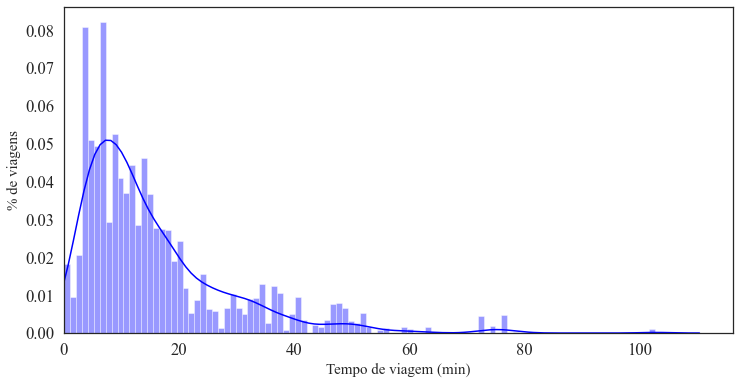

In [342]:
#Plotar distribuicao das distâncias de viagem
fig1, ax1=plt.subplots(1, figsize=(12,6))
# fig1.suptitle('Distribuicao do tempo de viagem', fontsize=20, fontweight='bold')

ax1=sns.distplot(bici_prin["tempo_m"],bins=100, hist=True, kde=True, hist_kws={"weights":bici_prin["fe_via"]/(bici_prin["fe_via"].sum())}, axlabel="Distância (m)", color="blue").set(xlim=(0))
plt.xlabel('Tempo de viagem (min)', fontsize=15)
plt.ylabel('% de viagens', fontsize=15)



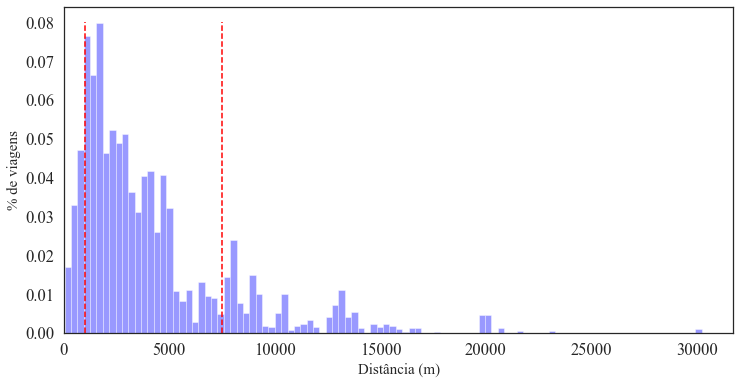

In [343]:
#Plotar distribuicao das distâncias de viagem
fig1, ax1=plt.subplots(1, figsize=(12,6))
# fig1.suptitle('Distribuição das distâncias percorridas', fontsize=20, fontweight='bold')

ax1=sns.distplot(bici_prin["distancia_m"],bins=100, hist=True, kde=False, hist_kws={"weights":bici_prin["fe_via"]/(bici_prin["fe_via"].sum())}, axlabel="Distância (m)", color="blue").set(xlim=(0))
plt.xlabel('Distância (m)', fontsize=15)
plt.ylabel('% de viagens', fontsize=15)
plt.vlines(x=[1000,7500], ymin=0, ymax=0.08, colors="red",linestyles="dashed")
plt.savefig("OD_distância_viagem.png", dpi=400)


In [ ]:
# Distribuicao percentual das distâncias de viagem
print((bici_prin[bici_prin["distancia_m"]<1000]["fe_via"].sum()/bici_prin["fe_via"].sum())*100,"% das viagens sao menores que 1km")
print((bici_prin[bici_prin["distancia_m"]<2000]["fe_via"].sum()/bici_prin["fe_via"].sum())*100,"% das viagens sao menores que 2km")
print((bici_prin[bici_prin["distancia_m"]<3000]["fe_via"].sum()/bici_prin["fe_via"].sum())*100,"% das viagens sao menores que 3km")
print((bici_prin[bici_prin["distancia_m"]<4000]["fe_via"].sum()/bici_prin["fe_via"].sum())*100,"% das viagens sao menores que 4km")
print((bici_prin[bici_prin["distancia_m"]<5000]["fe_via"].sum()/bici_prin["fe_via"].sum())*100,"% das viagens sao menores que 5km")
print((bici_prin[bici_prin["distancia_m"]<7500]["fe_via"].sum()/bici_prin["fe_via"].sum())*100,"% das viagens sao menores que 7,5km")
print((bici_prin[bici_prin["distancia_m"]<10000]["fe_via"].sum()/bici_prin["fe_via"].sum())*100,"% das viagens sao menores que 10km")
print((bici_prin[((bici_prin["distancia_m"]<5000)&(bici_prin["distancia_m"]>1000))]["fe_via"].sum()/bici_prin["fe_via"].sum())*100,"% das viagens sao menores que 5km e maiores que 1km")
print((bici_prin[((bici_prin["distancia_m"]<7500)&(bici_prin["distancia_m"]>1250))]["fe_via"].sum()/bici_prin["fe_via"].sum())*100,"% das viagens sao menores que 7,5km e maiores que 1km")
print((bici_prin[((bici_prin["distancia_m"]<10000)&(bici_prin["distancia_m"]>1000))]["fe_via"].sum()/bici_prin["fe_via"].sum())*100,"% das viagens sao menores que 10km e maiores que 1km")

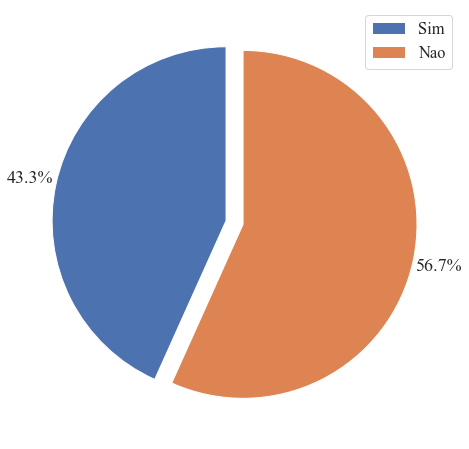

In [346]:
# Verificar se o ciclista utilizou alguma infraestrutura cicloviária ao longo do seu percurso
tipo_alerta= (bici_prin.groupby("via_bici")["fe_via"].sum()/bici_prin["fe_via"].sum())*100
labels = ["Sim","Nao"]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(1, figsize=(15,8))
ax1.pie(tipo_alerta, explode=explode, autopct='%1.1f%%',
        shadow=False, startangle=90, pctdistance=1.15)
  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels,
           loc="upper right")
# ax1.set_title("Utiizou via segregada?", size=20, weight='bold')
plt.savefig("OD_utilizou_via_segregada.png", dpi=400)

plt.show()

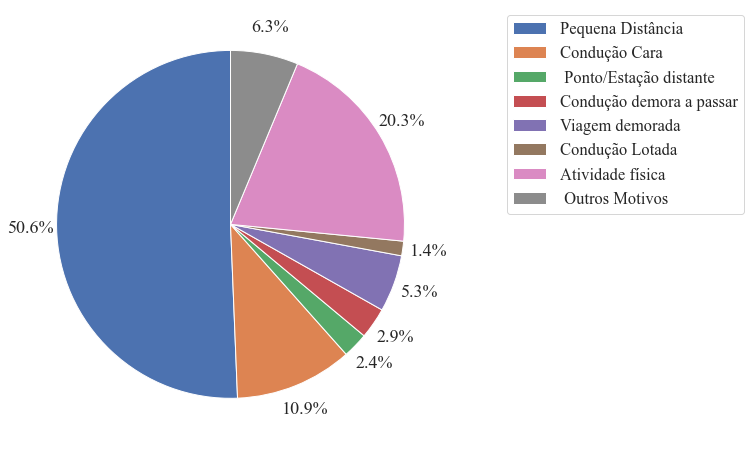

In [347]:
# Motivo pelo qual utilizou a bicicleta
tipo_alerta= (bici_prin.groupby("pe_bici")["fe_via"].sum()/bici_prin["fe_via"].sum())*100
labels = ["Pequena Distância","Condução Cara"," Ponto/Estação distante","Condução demora a passar","Viagem demorada","Condução Lotada","Atividade física"," Outros Motivos"]
#explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(1, figsize=(15,8))
ax1.pie(tipo_alerta, autopct='%1.1f%%',
        shadow=False, startangle=90, pctdistance=1.15)
  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels,
           loc="upper right", bbox_to_anchor=(1, 0, 0.7, 1))
# ax1.set_title("Razão pela escolha da bicicleta", size=20, weight='bold')
plt.savefig("OD_razao_escolha.png", dpi=400)

plt.show()

### ii. Descricao geral dos dados socioeconômicos dos ciclistas atuais


In [348]:
# Número de pessoas que utilizam a bicicleta como modo prinipal

print(bici_prin["f_pess"].sum(),"pesoas")
print("Equivalente a ", bici_prin[bici_prin["f_pess"]==1]["fe_pess"].sum(), "pessoas da populacao")

357.0 pesoas
Equivalente a  49144.89421535583 pessoas da populacao


([<matplotlib.axis.XTick at 0x20b26a56f88>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

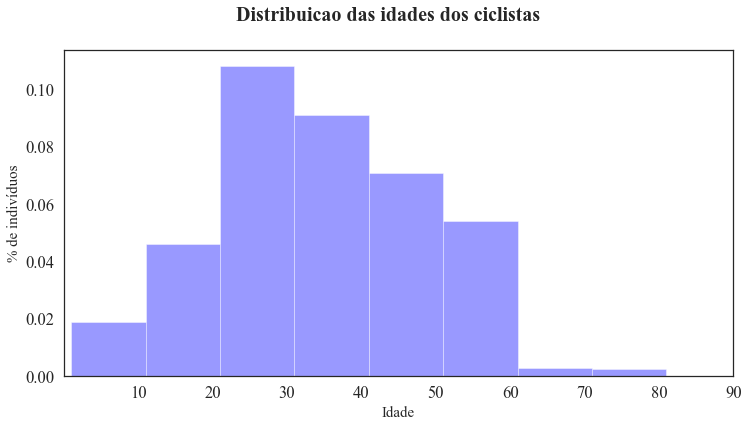

In [351]:
#Distribuicao das idades
fig1, ax1=plt.subplots(1, figsize=(12,6))
fig1.suptitle('Distribuicao das idades dos ciclistas', fontsize=20, fontweight='bold')

ax1=sns.distplot(bici_prin[bici_prin["f_pess"]==1]["idade"],bins=8, hist=True, kde=False, hist_kws={"weights":bici_prin[bici_prin["f_pess"]==1]["fe_via"]/(bici_prin["fe_via"].sum())}, axlabel="Idade", color="blue").set(xlim=(0))
plt.xlabel('Idade', fontsize=15)
plt.ylabel('% de indivíduos', fontsize=15)
plt.xticks([10,20,30,40,50,60,70,80,90])


In [352]:
#Concentracao das idades dos ciclistas
print(round(len((bici_prin[bici_prin["f_pess"]==1][(bici_prin[bici_prin["f_pess"]==1]["idade"]>16)&(bici_prin[bici_prin["f_pess"]==1]["idade"]<60)]))/len(bici_prin[bici_prin["f_pess"]==1])*100,2),"% das pessoas que utilizam a bicicleta como modo principal tem idade maior que 16 anos e menor que 60 anos")



90.2 % das pessoas que utilizam a bicicleta como modo principal tem idade maior que 16 anos e menor que 60 anos


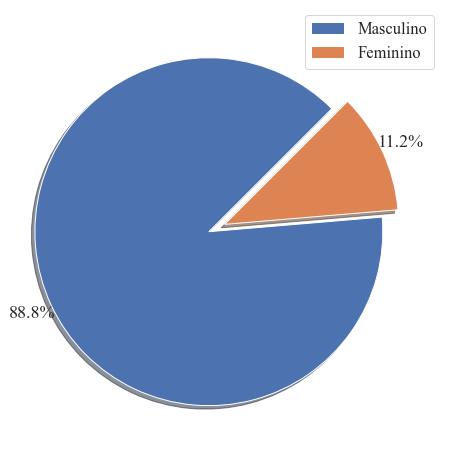

<Figure size 432x288 with 0 Axes>

In [354]:
# Gênero
tipo_alerta= (bici_prin[bici_prin["f_pess"]==1].groupby("sexo")["fe_pess"].sum()/bici_prin[bici_prin["f_pess"]==1]["fe_pess"].sum())*100
labels = ["Masculino","Feminino"]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(1, figsize=(15,8))
ax1.pie(tipo_alerta, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=45, pctdistance=1.12)
  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels,
           loc="upper right")
# ax1.set_title("Usuários de Bicicleta por sexo", size=20, weight='bold')


plt.show()
plt.savefig("OD_sexo.png", dpi=400)

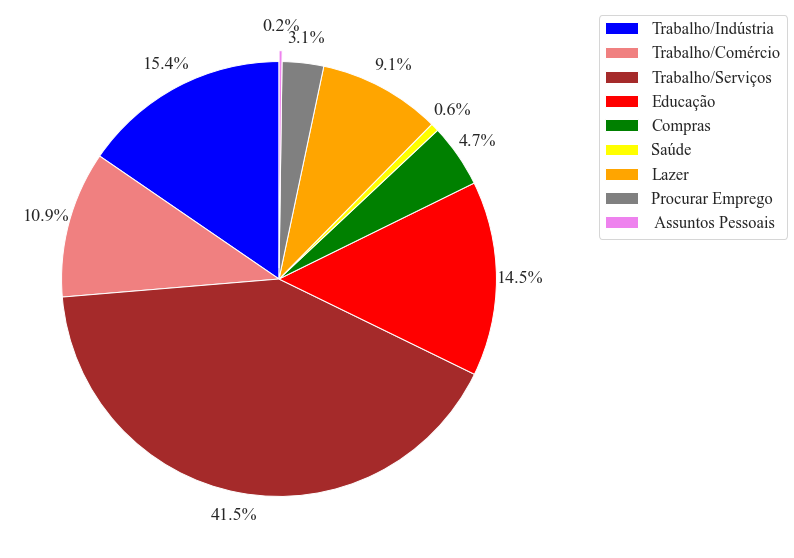

In [355]:
# Motivo de viagem
motivo_viagem = (bici_prin.groupby('motivo_viagem')['fe_via'].aggregate(np.sum)/bici_prin["fe_via"].sum())*100
labels = 'Trabalho/Indústria', 'Trabalho/Comércio', 'Trabalho/Serviços', 'Educação' , 'Compras','Saúde', 'Lazer','Procurar Emprego', ' Assuntos Pessoais'
sizes = motivo_viagem
explode = (0, 0, 0, 0,0,0, 0, 0, 0.05 )  # only "explode" the 2nd slice (i.e. 'Hogs')
colors=["blue","lightcoral","brown","red","green","yellow","orange","grey","violet","pink"]
fig1, ax1 = plt.subplots(1, figsize=(15,8))
ax1.pie(motivo_viagem, autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=90, pctdistance=1.11, explode=explode)
  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels,
           loc="upper right", bbox_to_anchor=(1, 0, 0.45, 1))
# ax1.set_title("Motivos de Viagem: Atuais ciclistas", size=20, weight='bold')
# fig1 = plt.gcf()
fig1.set_size_inches(15,10)
plt.savefig("C:/Users/Adm/Desktop/Lucas/Banco Mundial/Outputs/LCA Clustering/Outputs - Figuras/OD_motivo_viagem.png", dpi=400)
plt.show()


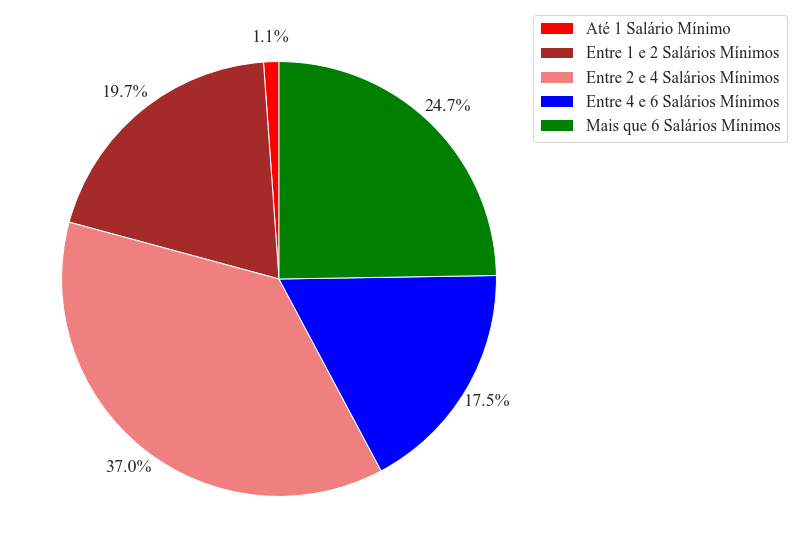

In [356]:
#Renda Familiar
faixa_renda= (bici_prin.groupby('faixa_renda_familiar')['fe_via'].aggregate(np.sum)/bici_prin["fe_via"].sum())*100
labels = 'Até 1 Salário Mínimo', 'Entre 1 e 2 Salários Mínimos', 'Entre 2 e 4 Salários Mínimos', 'Entre 4 e 6 Salários Mínimos' , 'Mais que 6 Salários Mínimos'
colors=["red","brown","lightcoral","blue","green"]
# explode = (0,0,0.05,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(1, figsize=(15,8))
ax1.pie(faixa_renda, autopct='%1.1f%%',
        shadow=False, startangle=90, pctdistance=1.11, colors=colors)
  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels,
           loc="upper right", bbox_to_anchor=(1, 0, 0.45, 1))
# ax1.set_title("Renda Familiar", size=20, weight='bold')
# fig1 = plt.gcf()
fig1.set_size_inches(15,10)
plt.savefig("C:/Users/Adm/Desktop/Lucas/Banco Mundial/Outputs/LCA Clustering/Outputs - Figuras/OD_renda_familiar.png", dpi=400)
plt.show()

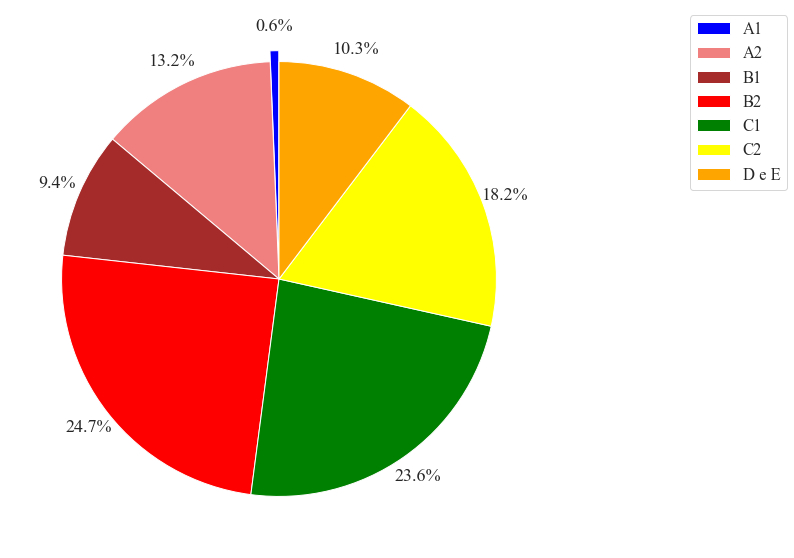

In [358]:
#Criterio de Classificacao Econômica
class_economica = (bici_prin.groupby('criteriobr')['fe_via'].aggregate(np.sum)/bici_prin["fe_via"].sum())*100
labels = 'A1', 'A2', 'B1', 'B2' , 'C1','C2', 'D e E'
colors=["blue","lightcoral","brown","red","green","yellow","orange"]

explode = (0.05,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(1, figsize=(15,8))
ax1.pie(class_economica, autopct='%1.1f%%',
        shadow=False, startangle=90, pctdistance=1.11, explode=explode, colors=colors)
  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels,
           loc="upper right", bbox_to_anchor=(1, 0, 0.45, 1))
# ax1.set_title("Critério Brasil", size=20, weight='bold')
# fig1 = plt.gcf()
fig1.set_size_inches(15,10)
plt.savefig("C:/Users/Adm/Desktop/Lucas/Banco Mundial/Outputs/LCA Clustering/Outputs - Figuras/OD_criterio_brasil.png", dpi=400)
plt.show()

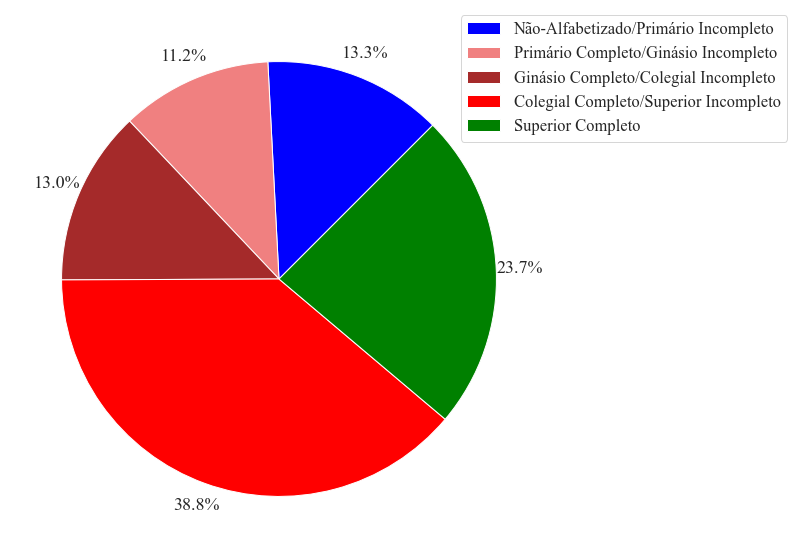

In [359]:
# Grau de Instrucao 
grau_instru = (bici_prin.groupby('grau_ins')['fe_via'].aggregate(np.sum)/bici_prin["fe_via"].sum())*100
labels = 'Não-Alfabetizado/Primário Incompleto', 'Primário Completo/Ginásio Incompleto', 'Ginásio Completo/Colegial Incompleto', 'Colegial Completo/Superior Incompleto' , 'Superior Completo'
colors=["blue","lightcoral","brown","red","green"]

sizes = grau_instru
explode = ( 0, 0 ,0, 0.1, 0)  

fig1, ax1 = plt.subplots(1, figsize=(15,8))
ax1.pie(grau_instru, autopct='%1.1f%%',
        shadow=False, startangle=45, pctdistance=1.11, colors=colors)
  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels,
           loc="upper right", bbox_to_anchor=(1, 0, 0.45, 1))
# ax1.set_title("Grau de Instrução", size=20, weight='bold')
# fig1 = plt.gcf()
fig1.set_size_inches(15,10)
plt.savefig("C:/Users/Adm/Desktop/Lucas/Banco Mundial/Outputs/LCA Clustering/Outputs - Figuras/OD_grau_instrucao.png", dpi=400)
plt.show()

## 2. Perfil Socioeconômico dos atuais ciclistas

Após análise descritiva das características dos atuais ciclistas (feita apenas para se ter conhecimento dessas características), a primeira etapa para o cálculo do CPI é identificar diferentes perfis socioeconômicos da amostra completa da populacao observada pela Pesquisa OD. Uma vez caracterizados todos os perfis socioeconômicos da amostra inteira, serao identificados quais os perfis que apresentam maior número de ciclistas. Esse subconjunto de perfis socioeconômicos podem ser entendidos como a parcela da populacao que possuem as mesmas características socioeconômicas que os atuais ciclistas. De maneira grosseira, podemos fazer a seguinte afirmacao: Se uma pessoa que nao usa a bicicleta apresenta as mesmas características de alguém que já a utiliza (mesma faixa de renda, grau de instrucao, quantidade de automóveis no domicílio, idade, sexo e etc), é mais provável que essa pessoa use a bicicleta quando comparada com alguém que possui um perfil socioeconômico de alguém que nao utiliza a bicicleta. 

Para determinar o perfil socioeconômico da amostra da OD, aplicou-se o método de Latent Class Cluster Analysis (LCCA), aplicado no R pelo pacote poLCA (Linzer DA, Lewis JB (2011). “poLCA: An R Package for Polytomous Variable Latent Class Analysis.” Journal of Statistical Software, 42(10), 1–29. https://www.jstatsoft.org/v42/i10/)

In [10]:
#Preparacao do banco de dados para o LCA

#Agrupar as viagens de bicicleta por indivíduo
lca_demand=od_2017.groupby("id_pess").first().reset_index()
lca_demand=lca_demand[["id_pess","idade","sexo","faixa_renda_familiar","grau_ins", "qt_auto","qt_moto","no_morad","criteriobr"]]
lca_demand=lca_demand[lca_demand["idade"]>12]
lca_demand=lca_demand[lca_demand["criteriobr"]>0]
lca_demand["entre_12_16_anos"]=np.where(((lca_demand["idade"]>12)&(lca_demand["idade"]<=16)),1,0)
lca_demand["entre_16_25_anos"]=np.where(((lca_demand["idade"]>16)&(lca_demand["idade"]<=25)),1,0)
lca_demand["entre_25_40_anos"]=np.where(((lca_demand["idade"]>25)&(lca_demand["idade"]<=40)),1,0)
lca_demand["entre_40_60_anos"]=np.where(((lca_demand["idade"]>40)&(lca_demand["idade"]<=60)),1,0)
lca_demand["mais_60_anos"]=np.where(lca_demand["idade"]>60,1,0)

#Criar Dummies para variáveis categóricas
#Renda Familiar - Até 1SM é a variável de referência
dummy_renda=pd.get_dummies(lca_demand["faixa_renda_familiar"], drop_first=False)
dummy_renda.columns=["Ate_1_Salario_Minimo","Entre_1_2_Salarios_Minimos","Entre_2_4_Salarios_Minimos","Entre_4_6_Salarios_Minimos","Mais_6_Salarios_Minimos"]
lca_demand=pd.merge(lca_demand, dummy_renda,left_index=True, right_index=True )
del lca_demand["faixa_renda_familiar"]

#Critério de classificacao econômica
lca_demand["Classe_A"]=np.where(lca_demand["criteriobr"]==1,1,0)
lca_demand["Classe_B"]=np.where(((lca_demand["criteriobr"]==2)|(lca_demand["criteriobr"]==3)),1,0)
lca_demand["Classe_C"]=np.where(((lca_demand["criteriobr"]==4)|(lca_demand["criteriobr"]==5)),1,0)
lca_demand["Classe_D_e_E"]=np.where(lca_demand["criteriobr"]==6,1,0)
                          
                                

#Grau de instrucao - Nao Alfabetizado é a variável de referência
dummy_instrucao=pd.get_dummies(lca_demand["grau_ins"], drop_first=True)
dummy_instrucao.columns=["Fundamental_I_Completo","Fundamental_II_Completo", "Medio_Completo","Superior_Completo"]
lca_demand=pd.merge(lca_demand, dummy_instrucao,left_index=True, right_index=True )
del lca_demand["grau_ins"]

#Posse de auto e moto na família (nao ter posse é a referência)
lca_demand["posse_motor_fam"]=np.where(((lca_demand["qt_moto"]!=0 )| (lca_demand["qt_auto"]!=0)), 1,0)
del lca_demand["qt_auto"]
del lca_demand["qt_moto"]

#Sexo
lca_demand["sexo"]=np.where(lca_demand["sexo"]==1, 0, 1)

lca_demand=lca_demand.reset_index(drop=True)
lca_demand

,id_pess,idade,sexo,no_morad,criteriobr,entre_12_16_anos,entre_16_25_anos,entre_25_40_anos,entre_40_60_anos,mais_60_anos,...,Mais_6_Salarios_Minimos,Classe_A,Classe_B,Classe_C,Classe_D_e_E,Fundamental_I_Completo,Fundamental_II_Completo,Medio_Completo,Superior_Completo,posse_motor_fam
0,10001101,59.0,1,2.0,4.0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,10001102,21.0,1,2.0,4.0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,10002101,37.0,1,4.0,5.0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
3,10002102,19.0,1,4.0,5.0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,10002103,18.0,0,4.0,5.0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29192,5162990102,58.0,1,2.0,1.0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,1,1
29193,5163023101,46.0,0,3.0,1.0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,1,1
29194,5164074102,45.0,0,4.0,1.0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,1,1
29195,5164580101,47.0,0,4.0,1.0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,1,1


In [371]:
# Salvar dataframe para aplicacao do poLCA no R
lca_demand.to_csv("lca.csv")

**Resultados**

In [ ]:
# Resultados estatísticos
results_lca=pd.read_csv("LCA Clustering Results.csv",sep=";")
results_lca.sort_values(by="BIC")

# A quantidade de perfis socioeconômicos (N) com o melhor fit na amostra é dado pelo critério de menor BIC (ver gráfico abaixo)
# Nesse caso, o menor BIC foi o resultado para 43 clusters ou perfis socioeconômicos da amostra
# Dos 43 clusters, 18 deles possuem 90% dos ciclistas da cidade. Logo, esses 18 clusters formam os perfis socioeconômicos dos atuais ciclistas de Sao Paulo

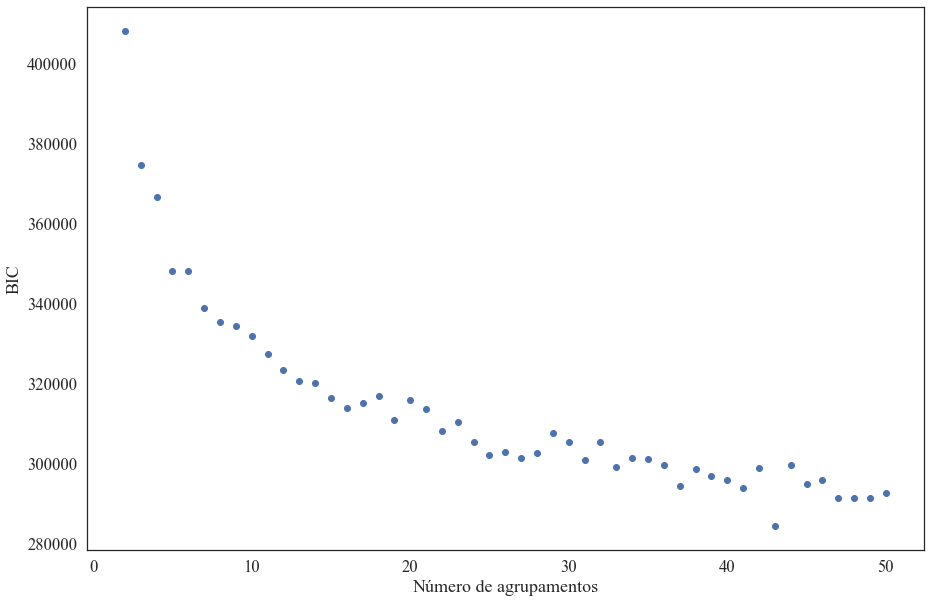

In [367]:
# Estatística BIC para escolha do número de Clusters
x= results_lca["N"]
y=results_lca["BIC"]
  

fig1, ax1 = plt.subplots(1, figsize=(15,8))
ax1.scatter(x,y)

plt.xlabel("Número de agrupamentos")
plt.ylabel("BIC")
  # Equal aspect ratio ensures that pie is drawn as a circle.

# ax1.set_title("Grau de Instrução", size=20, weight='bold')
# fig1 = plt.gcf()
fig1.set_size_inches(15,10)
plt.savefig("lca.png", dpi=400)
plt.show()

In [11]:
# Loading dos resultados obtidos do LCA no R pelo pacote poLCA
LCA_demand=pd.read_csv("C:/Users/Adm/Desktop/Lucas/Banco Mundial/Outputs/LCA Clustering/bicicleta_LCA.csv")
results_demand=pd.merge( LCA_demand[["state"]], lca_demand,left_index=True, right_index=True)
results_demand

,state,id_pess,idade,sexo,no_morad,criteriobr,entre_12_16_anos,entre_16_25_anos,entre_25_40_anos,entre_40_60_anos,...,Mais_6_Salarios_Minimos,Classe_A,Classe_B,Classe_C,Classe_D_e_E,Fundamental_I_Completo,Fundamental_II_Completo,Medio_Completo,Superior_Completo,posse_motor_fam
0,6,10001101,59.0,1,2.0,4.0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
1,9,10001102,21.0,1,2.0,4.0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,19,10002101,37.0,1,4.0,5.0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,9,10002102,19.0,1,4.0,5.0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,9,10002103,18.0,0,4.0,5.0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29192,5,5162990102,58.0,1,2.0,1.0,0,0,0,1,...,1,1,0,0,0,0,0,0,1,1
29193,5,5163023101,46.0,0,3.0,1.0,0,0,0,1,...,1,1,0,0,0,0,0,0,1,1
29194,5,5164074102,45.0,0,4.0,1.0,0,0,0,1,...,1,1,0,0,0,0,0,0,1,1
29195,5,5164580101,47.0,0,4.0,1.0,0,0,0,1,...,1,1,0,0,0,0,0,0,1,1


O principal output do poLCA é a identificacao do cluster de cada indivíduo em um dos perfis socioeconômicos da amostra da OD. É identificado pela coluna "state". Em seguida, temos que identificar quais os clusters com maior número de ciclistas

In [13]:
# Quantidade de ciclistas em cada perfil socioeconômico
bici_state_size=demand[demand["modoprin"]==15].groupby("state").size().reset_index()
bici_state_size=bici_state_size.sort_values(by=0, ascending=False).reset_index(drop=True)
bici_state_size=bici_state_size[bici_state_size["state"]!=0].reset_index(drop=True)
bici_state_size

,state,0
0,19.0,101
1,5.0,75
2,39.0,74
3,23.0,72
4,33.0,66
5,6.0,55
6,10.0,52
7,11.0,50
8,9.0,40
9,37.0,39


Acima, temos 32 com ao menos um ciclista. Mas podemos perceber que existem muitos clusters com poucos. Portanto, o próximo passo é usar um cut-off percentual com os clusters que apresentam 85% dos ciclistas

In [375]:
# Cutoff 85%
bici_state_size["obs"]=0
i=0
while bici_state_size["obs"].sum()<933*0.85:
    bici_state_size.at[i,"obs"]=bici_state_size.at[i,0]
    i=i+1

bici_state_size=bici_state_size[bici_state_size["obs"]!=0]

In [376]:
# Como resultado, identificamos 17 clusters que representam 85% da amostra de ciclistas. 
# Isso significa dizer que todos os indivíduos pertencentes a esses clusters possuem o mesmo perfil socioeconômico que 
# a maior parte dos ciclistas atuais de Sao Paulo
bici_state_size

,state,0,obs
0,19.0,101,101
1,5.0,75,75
2,39.0,74,74
3,23.0,72,72
4,33.0,66,66
5,6.0,55,55
6,10.0,52,52
7,11.0,50,50
8,9.0,40,40
9,37.0,39,39


## iii. Filtros Demanda Potencial


**Perfil Socioeconômico:**
Os estados que compoem 90% dos ciclistas sao 17.

Do resultado anterior, vamos voltar ao banco de dados de toda a amostra da OD e filtrar apenas aqueles que possuem o mesmo perfil socioeconômico dos atuais ciclistas.Ou seja, aqueles pertencentes aos clusters identificados no passo anterior. 

In [380]:
potential_demand=demand[(demand["state"]==19)|(demand["state"]==5)|(demand["state"]==39)|
             (demand["state"]==23)|(demand["state"]==33)|(demand["state"]==6)|
             (demand["state"]==10)|(demand["state"]==11)|(demand["state"]==9)|
             (demand["state"]==37)|(demand["state"]==15)|(demand["state"]==38)|(demand["state"]==42)|
                       (demand["state"]==36)|(demand["state"]==20)|(demand["state"]==1)|(demand["state"]==7)].reset_index(drop=True)

potential_demand=potential_demand[potential_demand["modoprin"]!=15] # Retirar aqueles indivíduos que já utilizam a bicicleta
potential_demand # O banco de dados "potential_demand" é referente às viagens realizadas pelos indivíduos que possuem o perfil socioeconômico encontrado

,Unnamed: 0,Unnamed: 0.1,zona,muni_dom,co_dom_x,co_dom_y,id_dom,f_dom,fe_dom,dom,...,declividade_mean,declividade_max_rota,distancia_osmnx_suitability,declividade_mean_rota_suitability,declividade_max_rota_suitability,distancia_osmnx_<12%,declividade_mean_rota_<12%,declividade_max_rota_<12%,% viagens,state
0,0,0.0,1.0,36.0,333743.0,7394463.0,10001,1.0,15.416667,1.0,...,0.012161,0.123,1929.229,0.012161,0.123,999.000,999.000000,999.000,0.0,6.0
1,1,1.0,1.0,36.0,333743.0,7394463.0,10001,0.0,15.416667,1.0,...,-0.008857,0.072,1810.176,-0.008857,0.072,5430.756,0.002529,0.094,0.0,6.0
2,2,2.0,1.0,36.0,333814.0,7394428.0,10002,1.0,15.416667,2.0,...,0.019783,0.123,1409.915,0.019783,0.123,2221.694,0.003120,0.064,0.0,19.0
3,3,3.0,1.0,36.0,333814.0,7394428.0,10002,0.0,15.416667,2.0,...,-0.028250,0.034,841.069,-0.028250,0.034,841.069,-0.028250,0.034,0.0,19.0
4,4,4.0,1.0,36.0,333814.0,7394428.0,10002,0.0,15.416667,2.0,...,0.019783,0.123,1409.915,0.019783,0.123,2221.694,0.003120,0.064,0.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56016,86954,89089.0,394.0,26.0,362020.0,7395317.0,3940311,0.0,65.608696,311.0,...,-0.018250,0.075,2821.145,-0.021800,0.060,3609.136,-0.012511,0.090,0.0,6.0
56017,86956,89091.0,466.0,9.0,313453.0,7385740.0,4660904,0.0,461.538462,904.0,...,0.009586,0.117,9634.190,0.008116,0.117,10273.388,0.009321,0.063,0.0,19.0
56018,86957,89092.0,468.0,16.0,316295.0,7378948.0,4680065,0.0,496.746453,65.0,...,-0.002271,0.143,13819.757,-0.002467,0.055,999.000,999.000000,999.000,0.0,42.0
56019,86958,89093.0,483.0,2.0,300470.0,7400199.0,4830019,0.0,70.000000,19.0,...,0.011200,0.087,7044.485,0.008343,0.145,999.000,999.000000,999.000,0.0,5.0


In [387]:
print((len(potential_demand.groupby("id_pess").first())/len(demand.groupby("id_pess").first()))*100,"% dos individuos observados possem características semelhantes aos atuais ciclistas")

61.128951477476946 % dos individuos observados possem características semelhantes aos atuais ciclistas


In [388]:
potential_demand["fe_via"].sum()/demand["fe_via"].sum() # % do número de viagens que essas pessoas fizeram

0.616804145762252

**Filtro Inclinacao**: Para aplicar o filtro inclinacao, uma etapa anterior foi realizada em um script à parte. No Script à parte, foram calculadas as rotas de menor distância entre cada para origem-destino. A rede utilizada foi extraída do Open Street Maps, da qual foram excluídos todos os arcos que nao ofereciam inclinacoes compatíveis com o uso da bicicleta de acordo com o Manual de Desenho Cicloviário da Catalunha. Ou seja, com a exclusao de alguns arcos da rede, certos pares origem-destino nao possuem uma rota estabelecida. Logo, o filtro de inclinacao se estabelece a partir da exclusao dessas viagens. Isso indica que uma viagem de bicicleta é inviável para esse para OD

In [389]:
# Filtro das viagens que nao possuem rotas estabelecidas
potential_demand=potential_demand[potential_demand["distancia_osmnx_<12%"]!=999].reset_index(drop=True)
potential_demand

,Unnamed: 0,Unnamed: 0.1,zona,muni_dom,co_dom_x,co_dom_y,id_dom,f_dom,fe_dom,dom,...,declividade_mean,declividade_max_rota,distancia_osmnx_suitability,declividade_mean_rota_suitability,declividade_max_rota_suitability,distancia_osmnx_<12%,declividade_mean_rota_<12%,declividade_max_rota_<12%,% viagens,state
0,1,1.0,1.0,36.0,333743.0,7394463.0,10001,0.0,15.416667,1.0,...,-0.008857,0.072,1810.176,-0.008857,0.072,5430.756,0.002529,0.094,0.0,6.0
1,2,2.0,1.0,36.0,333814.0,7394428.0,10002,1.0,15.416667,2.0,...,0.019783,0.123,1409.915,0.019783,0.123,2221.694,0.003120,0.064,0.0,19.0
2,3,3.0,1.0,36.0,333814.0,7394428.0,10002,0.0,15.416667,2.0,...,-0.028250,0.034,841.069,-0.028250,0.034,841.069,-0.028250,0.034,0.0,19.0
3,4,4.0,1.0,36.0,333814.0,7394428.0,10002,0.0,15.416667,2.0,...,0.019783,0.123,1409.915,0.019783,0.123,2221.694,0.003120,0.064,0.0,19.0
4,5,5.0,1.0,36.0,333814.0,7394428.0,10002,0.0,15.416667,2.0,...,-0.028250,0.034,841.069,-0.028250,0.034,841.069,-0.028250,0.034,0.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48067,86947,89082.0,342.0,36.0,323101.0,7392005.0,3420519,0.0,276.505586,519.0,...,0.001301,0.128,7540.895,-0.002131,0.128,9560.133,0.001896,0.064,0.0,9.0
48068,86948,89083.0,342.0,36.0,323101.0,7392005.0,3420519,0.0,276.505586,519.0,...,0.006818,0.110,6105.549,0.005107,0.055,6025.064,0.005685,0.055,0.0,9.0
48069,86954,89089.0,394.0,26.0,362020.0,7395317.0,3940311,0.0,65.608696,311.0,...,-0.018250,0.075,2821.145,-0.021800,0.060,3609.136,-0.012511,0.090,0.0,6.0
48070,86956,89091.0,466.0,9.0,313453.0,7385740.0,4660904,0.0,461.538462,904.0,...,0.009586,0.117,9634.190,0.008116,0.117,10273.388,0.009321,0.063,0.0,19.0


**Filtro Distância de Viagem:**
A partir das rotas estabelecidas na rede descrita no passo do Filtro de Distância de viagem, foram excluídas as viagens a pé menores que 1,25 km e as viagens por modos motorizados acima de 7,5 km (já que 90% dos ciclistas viajam a distâncias menores que essa)

In [392]:
potential_a_pe=potential_demand[(potential_demand["distancia_osmnx_<12%"]>1250)&(potential_demand["modo1"]==16)].reset_index(drop=True)
potential_demand=potential_demand[potential_demand["modo1"]!=16].reset_index(drop=True)
potential_demand=pd.concat([potential_demand,potential_a_pe]).reset_index(drop=True)
potential_demand=potential_demand[potential_demand["distancia_osmnx_<12%"]<7500].reset_index(drop=True)
potential_demand

,Unnamed: 0,Unnamed: 0.1,zona,muni_dom,co_dom_x,co_dom_y,id_dom,f_dom,fe_dom,dom,...,declividade_mean,declividade_max_rota,distancia_osmnx_suitability,declividade_mean_rota_suitability,declividade_max_rota_suitability,distancia_osmnx_<12%,declividade_mean_rota_<12%,declividade_max_rota_<12%,% viagens,state
0,23745,25433.0,1.0,36.0,333743.0,7394463.0,10001,0.0,15.416667,1.0,...,-0.005162,0.169,6587.758,-0.002030,0.095,6718.530,-0.003343,0.095,0.0,9.0
1,23752,25440.0,1.0,36.0,333012.0,7394687.0,10665,1.0,30.038462,665.0,...,-0.002933,0.140,1914.622,-0.002933,0.140,3325.856,-0.003586,0.061,0.0,19.0
2,23753,25441.0,1.0,36.0,333012.0,7394687.0,10665,0.0,30.038462,665.0,...,0.015200,0.137,2521.128,0.014133,0.137,2744.553,0.016192,0.085,0.0,19.0
3,23754,25442.0,1.0,36.0,333012.0,7394687.0,10665,0.0,30.038462,665.0,...,-0.002933,0.140,1914.622,-0.002933,0.140,3325.856,-0.003586,0.061,0.0,19.0
4,23755,25443.0,1.0,36.0,333012.0,7394687.0,10665,0.0,30.038462,665.0,...,0.015200,0.137,2521.128,0.014133,0.137,2744.553,0.016192,0.085,0.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25710,70274,72380.0,499.0,24.0,316876.0,7400002.0,4991992,0.0,302.456766,1992.0,...,-0.004214,0.064,2589.292,-0.010893,0.055,2559.768,-0.004214,0.064,0.0,11.0
25711,70275,72381.0,500.0,24.0,318237.0,7399539.0,5000002,0.0,190.000000,2.0,...,-0.000167,0.071,1401.536,-0.001727,0.059,1401.536,-0.001727,0.059,0.0,19.0
25712,70293,72401.0,516.0,31.0,312175.0,7402685.0,5162821,0.0,291.658537,2821.0,...,0.008813,0.033,1680.830,0.008813,0.033,1680.830,0.008813,0.033,0.0,37.0
25713,70294,72402.0,516.0,31.0,312175.0,7402685.0,5162821,0.0,291.658537,2821.0,...,0.001000,0.025,1623.318,0.001000,0.025,1623.318,0.001000,0.025,0.0,37.0


## 4. Descricao Geral das viagens potencialmente cicláveis

Uma vez determinada quais sao as viagens potencialmente cicláveis e quais pessoas as realizam, é possível apresentar uma descricao desses dados em relacao a:

a) Características individuais das pessoas que realizam viagens potencialmente cicláveis (idade, gênero);
b) Características de viagem (modo atual,  tempo de viagem, motivo de viagem);
c) Características espaciais (origem e destino de viagem)